In [177]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from pandas import ExcelWriter
from pandas import ExcelFile
#natural language section
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
#graphs/plots
import matplotlib.pyplot as plt
#wordclouds
from os import path
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from unidecode import unidecode
import os
from PIL import Image
import urllib
import requests
%matplotlib inline

In [173]:
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
tqdm_notebook.pandas('Progress')

In [100]:
data = pd.read_excel('C:\\Users\\Violet\\Desktop\\KingKola.xlsx', sheet_name='Sheet1')

print("Column headings:")
print(data.columns)

Column headings:
Index(['id', 'sample_id', 'created', 'kingkola_DATA_SET',
       'amica_qd_sport_viewership - baseball',
       'amica_qd_sport_viewership - basketball',
       'amica_qd_sport_viewership - football',
       'amica_qd_sport_viewership - golf', 'amica_qd_sport_viewership - none',
       'amica_qd_sport_viewership - soccer',
       ...
       '$SLTV_Viewers', '$Spanish_Dominant', '$fulcrum_language',
       '$fulcrum_origin_mexican_non', '$hispanic_origin_region', '$ignored',
       '$kf_fulcrum_sl_home_optimized', '$kf_fulcrum_sl_home_optimized_sports',
       '$univision_language', 'all_respondents'],
      dtype='object', length=401)


In [101]:
#looking at the first 10 rows of raw data
data.head(10)

,id,sample_id,created,kingkola_DATA_SET,amica_qd_sport_viewership - baseball,amica_qd_sport_viewership - basketball,amica_qd_sport_viewership - football,amica_qd_sport_viewership - golf,amica_qd_sport_viewership - none,amica_qd_sport_viewership - soccer,...,$SLTV_Viewers,$Spanish_Dominant,$fulcrum_language,$fulcrum_origin_mexican_non,$hispanic_origin_region,$ignored,$kf_fulcrum_sl_home_optimized,$kf_fulcrum_sl_home_optimized_sports,$univision_language,all_respondents
0,2402636,__skuty_TEST_2018-02-12T22:14:12.085Z,2018-02-12,NaN,no,no,no,no,yes,no,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,all_respondents
1,2405218,__jlendor_TEST_2018-02-13T19:43:36.212Z,2018-02-13,NaN,yes,yes,yes,yes,no,yes,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,all_respondents
2,2405224,__skuty_TEST_2018-02-13T20:00:32.155Z,2018-02-13,NaN,yes,no,yes,yes,no,yes,...,NaN,NaN,NaN,NaN,NaN,yes,English Mostly,NaN,English Mostly,all_respondents
3,2405227,__jlendor_TEST_2018-02-13T20:11:02.618Z,2018-02-13,NaN,no,no,no,no,yes,no,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,all_respondents
4,2405228,__skuty_TEST_2018-02-13T20:11:17.163Z,2018-02-13,NaN,no,no,yes,no,no,no,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,all_respondents
5,2405231,__skuty_TEST_2018-02-13T20:22:01.195Z,2018-02-13,NaN,no,no,no,no,yes,no,...,NaN,1.0,NaN,NaN,NaN,yes,Spanish Only,NaN,Spanish Only,all_respondents
6,2405237,__jlendor_TEST_2018-02-13T20:37:14.934Z,2018-02-13,NaN,no,no,no,no,yes,no,...,NaN,1.0,NaN,NaN,NaN,yes,Spanish Only,NaN,Spanish Only,all_respondents
7,2405247,EE3CEDC9-0411-E811-81A3-D9EA891E9F4D,2018-02-13,NaN,yes,yes,yes,yes,no,yes,...,SLTV Viewers,1.0,Spanish Mostly,Non-Mexican,South America,NaN,Spanish Mostly,NaN,Spanish Mostly,all_respondents
8,2405250,AF28CEE7-0411-E811-81A3-D9EA891E9F4D,2018-02-13,NaN,yes,yes,yes,yes,no,yes,...,NaN,1.0,Spanish Mostly,NaN,NaN,NaN,Spanish Mostly,NaN,Spanish Mostly,all_respondents
9,2405252,36DEC0F3-0411-E811-81A3-D9EA891E9F4D,2018-02-13,NaN,no,no,no,yes,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,all_respondents


In [260]:
#looking for the columns that contain the text data that needs to be analyzed
#print(data.columns.values)

In [143]:
#the column that I neeed to find gibberish words and delete the ids"
#data['kingkola_q08_unaided_gen_recall']

Creating wordclouds to see the most frequent words written by participants

In [261]:
#looking at the different exposures so we can separate the themes by exposure
exposures = df.groupby("$kingkola_Non_Dials")
exposures.size().sort_values(ascending=False).head()


$kingkola_Non_Dials
Paintball 30    1734
Anthem - EL     1694
Anthem - SL      876
dtype: int64

We are not looking at Anthem-SL because the exposure is in Spanish

In [103]:
def default_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs: 'color_set'):
    selected_theme = 'default'
    color_sets = {
        'default': {
            'blue': (67, 141, 156),
            'yellow': (232, 166, 100),
            'brown': (156, 96, 67),
            'black': (23, 23, 23),
            'red': (204, 0, 0)
        }
    }
    
    color, (r, g, b) = random.choice(list(color_sets[selected_theme].items()))
    return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [149]:
def generate_cloud(demo_cuts, wordcloud_rids, xl_fn, wc_fn):
    additional_stopwords = ["dislike", "the", "and", "company", "want","all","lot","us","see","going", "nan", "kingkola", "disliked","ad", "nothing","really","anything","none"]

    for word in additional_stopwords:
        STOPWORDS.add(word)

    for column_name, population_names in populations.items():

        for population_name in population_names:

            writer = pd.ExcelWriter(
                xl_fn,
                engine='xlsxwriter'
            )

            for key, demo_cut in demo_cuts.items():

                for item in demo_cut:

                    for label, rid in wordcloud_rids.items():

                        limited_data = data.loc[(data[key] == item) & (data[column_name] == population_name)]
                        responses = limited_data[rid]

                        responses_string = ""
                        for response in responses:
                            responses_string = responses_string + " " + unidecode(str(response)).lower()

                        wordcloud = WordCloud(width=1000,
                                              height=1000,
                                              background_color='white',
                                              font_path='C:\\Users\\Violet\\Desktop\\Arimo-Regular.ttf',
                                              stopwords=STOPWORDS,
                                              min_font_size=12,
                                              max_font_size=400,
                                              prefer_horizontal=0.6,
                                              relative_scaling=0.75)

                        wordlist = {word: count for word, count in wordcloud.process_text(responses_string).items() if count > 2}
                        sorted_wordlist = sorted(wordlist.items(), key=lambda kv: kv[1], reverse=True)
                        wordlist_df = pd.DataFrame.from_dict(sorted_wordlist)
                        wordlist_df.to_excel(writer, sheet_name=f'{item} {label}', header=False, index=False)

                        wordcloud.generate_from_frequencies(wordlist)
                        wordcloud.recolor(color_func=default_color_func)
                        wordcloud.to_file(wc_fn)

            writer.save()

In [150]:
# Where you want the files to save
    # NOTE: if you're saving in sub-folders (like this example) create it first
    # wordcount_file_location = f'{population_name}/{population_name}_Politics_Wordcloud_Wordcounts.xlsx'
    # wordclouds_location = f'{population_name}/{item} {label}.png'
wordcount_file_location = 'C:\\Users\\Violet\\Desktop\\paintball_dislike_most_all.xlsx'
wordclouds_location = 'C:\\Users\\Violet\\Desktop\\paintball_dislike_most_all.png'

    # The most granular cuts you want
demo_cuts = {
        'all_respondents': ['all_respondents']
        # '$Puerto_Rican_Origin': ["Puerto Rican", "Non-Puerto Rican Hispanic"]
        # '$MP_Univision_Viewer': ["1"],
        # '$MP_Hispanic': ['Non-Hispanic']
    }

    # The column name of the text data you want a wordcloud for
wordcloud_rids = {
        # 'q05_northwell': 'northwell_q05_unaided_concerns',
        'q12_paint_disl': 'kingkola_q13_unaided_dislike_most_paintball_30'

    }

    # The populations you want to limit by
populations = {
         'all_respondents': ["all_respondents"]
    }

    # Runs the function
generate_cloud(demo_cuts, wordcloud_rids, wordcount_file_location, wordclouds_location)

Topic-Modeling

Cleaning up the text with spacy

In [182]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [193]:
anthem_like= data.kingkola_q12_unaided_like_most_anthem_30.fillna("")
anthem_dislike= data.kingkola_q13_unaided_dislike_most_anthem_30.fillna("")
paintball_like= data.kingkola_q12_unaided_like_most_paintball_30.fillna("")
paintball_dislike= data.kingkola_q13_unaided_dislike_most_paintball_30.fillna("")

def clean_up_spacy(text):
    text_out = set()
    clean = re.sub("\s\s+",',',text)
    clean =re.sub("'|•|<br/>","",clean)
    clean =re.sub(r'\w*(?=\\|:)','',clean)
    text = re.sub("xa0|\\\\|:",',',clean)
    text = re.sub("(?<=\w)\s(?=\w+\,)",'_',text)
    text = re.sub("(?<=\w)\s(?=\w+)",'',text)
    text = re.sub(r"\[|]",' ',text)
    text = ' '.join(text.split(','))

    removal1= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','VERB','ADJ','SYM','NOUN','X','NUM','SPACE']
    doc= nlp(text)
    for token in doc:
        
        if token.string == token.string.upper() and len(token)<15 and token.is_punct is False and token.is_alpha: 
            lemma = token.lemma_.strip() 
            text_out.add(lemma)            
        if  token.pos_ not in removal1 and len(token)<15 and token.is_punct is False :
            lemma = token.lemma_.strip()
            if lemma != '':
                text_out.add(lemma)
    text_out = list(text_out)
    return text_out

In [194]:
anthem_likeList = anthem_like.progress_apply(lambda x:clean_up_spacy(x))
anthem_dislikeList = anthem_dislike.progress_apply(lambda x:clean_up_spacy(x))
paintball_likeList = paintball_like.progress_apply(lambda x:clean_up_spacy(x))
paintball_dislikeList = paintball_dislike.progress_apply(lambda x:clean_up_spacy(x))


In [190]:
finalList =[]
for sublist in anthem_likeList:
    for item in sublist:
        finalList.append(item)
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:10]

[('nan', 2808),
 ('kingkola', 12),
 ('CindyCrawford', 7),
 ('Cindy', 5),
 ('Itwasfunny', 5),
 ('MichaelJackson', 4),
 ('Allofit', 4),
 ('Thepeople', 3),
 ('Thenostalgia', 3),
 ('Michaeljackson', 3)]

Participants' like/dislike classification using LDA

In [195]:
finalList =[]
for sublist in anthem_dislikeList:
    for item in sublist:
        finalList.append(item)
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:10]

[('nan', 2842),
 ('Nothingatall', 16),
 ('nothingatall', 12),
 ('Ilikeditall', 8),
 ('nothing', 7),
 ('Na', 6),
 ('N', 5),
 ('kingkola', 4),
 ('Toolong', 3),
 ('Itskingkola', 3)]

In [196]:
finalList =[]
for sublist in paintball_likeList:
    for item in sublist:
        finalList.append(item)
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:10]

[('nan', 2754),
 ('Themusic', 21),
 ('kingkola', 11),
 ('Fun', 7),
 ('Messi', 6),
 ('Ilikedthemusic', 6),
 ('themusic', 5),
 ('Itwasfun', 5),
 ('messi', 4),
 ('Thepaint', 4)]

In [197]:
finalList =[]
for sublist in paintball_dislikeList:
    for item in sublist:
        finalList.append(item)
c =Counter(finalList)
sorted(c.items(), key=lambda x:x[1],reverse=True)[:10]

[('nan', 2791),
 ('nothingatall', 12),
 ('nothing', 10),
 ('Nothingatall', 10),
 ('Themusic', 7),
 ('kingkola', 6),
 ('Ilikeditall', 6),
 ('Nada', 5),
 ('N', 4),
 ('NONE', 4)]

In [222]:
dictionary_anthem_like = corpora.Dictionary(anthem_likeList)
dictionary_anthem_dislike = corpora.Dictionary(anthem_dislikeList)
dictionary_paintball_like = corpora.Dictionary(paintball_likeList)
dictionary_paintball_dislike = corpora.Dictionary(paintball_dislikeList)
doc_term_matrix_anthem_like = [dictionary_anthem_like.doc2bow(doc) for doc in anthem_likeList]
doc_term_matrix_anthem_dislike = [dictionary_anthem_dislike.doc2bow(doc) for doc in anthem_dislikeList]
doc_term_matrix_paintball_like = [dictionary_paintball_like.doc2bow(doc) for doc in paintball_likeList]
doc_term_matrix_paintball_dislike = [dictionary_paintball_dislike.doc2bow(doc) for doc in paintball_dislikeList]

In [223]:
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel

In [235]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(2,8)
for num_topics in tqdm(num_topics_list):
    lda= Lda(doc_term_matrix_anthem_like, num_topics=num_topics,id2word = dictionary_anthem_like, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix_anthem_like, 
                        dictionary=dictionary_anthem_like, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix_anthem_like,
                           texts=anthem_likeList, dictionary=dictionary_anthem_like, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix_anthem_like, dictionary_anthem_like)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

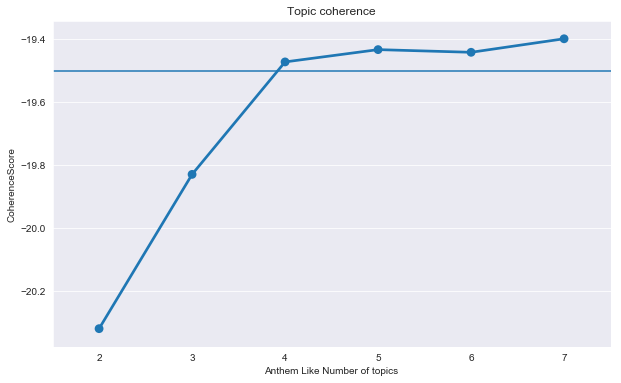

In [236]:
import seaborn as sns
plotData = pd.DataFrame({'Anthem Like Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Anthem Like Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-19.5)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [238]:
Lda_anthem_like = models.LdaMulticore
lda_final_anthem_like= Lda_anthem_like(doc_term_matrix_anthem_like, num_topics=3,id2word = dictionary_anthem_like, passes=20,chunksize=4000,random_state=43)

In [240]:
lda_final_anthem_like.save('lda_final Anthem like')
dictionary_anthem_like.save('dictionary_anthem_like')
corpora.MmCorpus.serialize('doc_term_matrix_anthem_like.mm', doc_term_matrix_anthem_like)

Anthem exposure Dislike Most

In [233]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(2,10)
for num_topics in tqdm(num_topics_list):
    lda= Lda(doc_term_matrix_anthem_dislike, num_topics=num_topics,id2word = dictionary_anthem_dislike, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix_anthem_dislike, 
                        dictionary=dictionary_anthem_dislike, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix_anthem_dislike,
                           texts=anthem_dislikeList, dictionary=dictionary_anthem_dislike, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix_anthem_dislike, dictionary_anthem_dislike)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

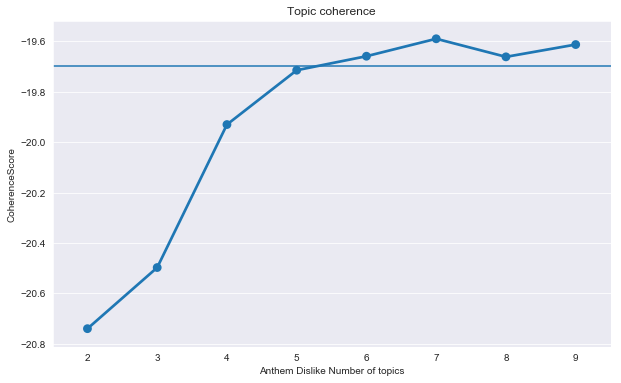

In [234]:
import seaborn as sns
plotData = pd.DataFrame({'Anthem Dislike Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Anthem Dislike Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-19.7)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [241]:
Lda_anthem_dislike = models.LdaMulticore
lda_final_anthem_dislike= Lda_anthem_dislike(doc_term_matrix_anthem_dislike, num_topics=4,id2word = dictionary_anthem_dislike, passes=20,chunksize=4000,random_state=43)

In [242]:
lda_final_anthem_dislike.save('lda_final Anthem dislike')
dictionary_anthem_dislike.save('dictionary_anthem_dislike')
corpora.MmCorpus.serialize('doc_term_matrix_anthem_dislike.mm', doc_term_matrix_anthem_dislike)

Topic Evaluation

In [245]:
lda_final_anthem_like =Lda_anthem_like.load('lda_final Anthem like')
dictionary_anthem_like = corpora.Dictionary.load('dictionary_anthem_like')
doc_term_matrix_anthem_like = corpora.MmCorpus('doc_term_matrix_anthem_like.mm')

In [256]:
a = lda_final_anthem_like.show_topics(num_topics=3,formatted=False,num_words=10)
b = lda_final_anthem_like.top_topics(doc_term_matrix_anthem_like,dictionary=dictionary_anthem_like,topn=10) # This orders the topics in the decreasing order of coherence score

topic2skillb = {}
topic2csb = {}
topic2skilla = {}
topic2csa = {}
num_topics =lda_final.num_topics
cnt =1

for ws in b:
    wset = set(w[1] for w in ws[0])
    topic2skillb[cnt] = wset
    topic2csb[cnt] = ws[1]
    cnt +=1

for ws in a:
    wset = set(w[0]for w in ws[1])
    topic2skilla[ws[0]+1] = wset
    
for i in range(1,num_topics+1):
    for j in range(1,num_topics+1):  
        if topic2skilla[i].intersection(topic2skillb[j])==topic2skilla[i]:
            topic2csa[i] = topic2csb[j]

finalData_anthem_like = pd.DataFrame([],columns=['Topic','words'])
finalData_anthem_like['Topic']=topic2skilla.keys()
finalData_anthem_like['Topic'] = finalData['Topic'].apply(lambda x: 'Topic'+str(x))
finalData_anthem_like['words']=topic2skilla.values()
finalData_anthem_like['cs'] = topic2csa.values()
finalData_anthem_like.sort_values(by='cs',ascending=False,inplace=True)
finalData_anthem_like.to_csv('CoherenceScore.csv')
finalData_anthem_like

,Topic,words,cs
1,TopicTopic2,"{Itsfunny, nan, Thenostalgia, fun, BritneySpea...",-21.663334
0,TopicTopic1,"{nan, thehumor, megustamucho, Itwasfun, thatit...",-21.678100
2,TopicTopic3,"{nan, thepeople, Itwasfunny, Allofit, Iloveit,...",-21.968757


In [257]:
num_topics =3
vis = pyLDAvis.gensim.prepare(lda_final_anthem_like, doc_term_matrix_anthem_like, dictionary_anthem_like,sort_topics=False)
pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.280949 -0.005247       1        1  61.890388
1     -0.151965 -0.093605       2        1  19.230103
2     -0.128984  0.098852       3        1  18.879513, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
0     Default  1991.000000             nan  1991.000000  30.0000  30.0000
2     Default    33.000000        kingkola    33.000000  29.0000  29.0000
56    Default    14.000000      Itwasfunny    14.000000  28.0000  28.0000
17    Default    14.000000           Cindy    14.000000  27.0000  27.0000
3     Default    12.000000  MichaelJackson    12.000000  26.0000  26.0000
77    Default    12.000000         Allofit    12.000000  25.0000  25.0000
70    Default     9.000000    Thenostalgia     9.000000  24.0000  24.0000
76    Default     9.000000  Michaeljackson     9.000000  23.0000  23.0000
166   Default     9.000000       Nostalgia     9.000000  22.0000  22.0000
90    Default     7.000000            Nice     7.000000  21.0000  21.0000
86    Default     7.000000             yes     7.000000  20.0000  20.0000
60    Default     7.000000         Iloveit     7.000000  19.0000  19.0000
49    Default     7.000000        itsfunny     7.000000  18.0000  18.0000
35    Default     7.000000       thepeople     7.000000  17.0000  17.0000
130   Default     7.000000          Upbeat     7.000000  16.0000  16.0000
108   Default     7.000000        Themusic     7.000000  15.0000  15.0000
10    Default     6.000000        Itsfunny     6.000000  14.0000  14.0000
5     Default     6.000000   thepeopleinit     6.000000  13.0000  13.0000
145   Default     6.000000   BritneySpears     6.000000  12.0000  12.0000
75    Default     6.000000        verynice     6.000000  11.0000  11.0000
94    Default     4.000000  l.;/kjhgfdvbnm     4.000000  10.0000  10.0000
163   Default     4.000000        allothem     4.000000   9.0000   9.0000
164   Default     4.000000  the_characters     4.000000   8.0000   8.0000
95    Default     4.000000        vgbhnjmk     4.000000   7.0000   7.0000
217   Default     4.000000         Britney     4.000000   6.0000   6.0000
218   Default     4.000000              MJ     4.000000   5.0000   5.0000
36    Default     4.000000          thecar     4.000000   4.0000   4.0000
118   Default     4.000000           Uniqu     4.000000   3.0000   3.0000
141   Default     4.000000            FINE     4.000000   2.0000   2.0000
29    Default     4.000000       IMNOTSURE     4.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
3      Topic3    11.235359  MichaelJackson    12.279255   1.5782  -3.9520
77     Topic3    11.235318         Allofit    12.279480   1.5782  -3.9520
90     Topic3     6.046883            Nice     7.090491   1.5079  -4.5716
86     Topic3     6.046851             yes     7.090502   1.5079  -4.5716
49     Topic3     6.046710        itsfunny     7.090357   1.5079  -4.5716
35     Topic3     6.046707       thepeople     7.090410   1.5079  -4.5716
60     Topic3     6.046814         Iloveit     7.090546   1.5079  -4.5716
108    Topic3     6.046556        Themusic     7.090411   1.5078  -4.5716
130    Topic3     6.046601          Upbeat     7.090518   1.5078  -4.5716
94     Topic3     3.455936  l.;/kjhgfdvbnm     4.496493   1.4039  -5.1310
163    Topic3     3.455925        allothem     4.496484   1.4039  -5.1310
164    Topic3     3.455914  the_characters     4.496480   1.4039  -5.1310
217    Topic3     3.455893         Britney     4.496465   1.4039  -5.1310
95     Topic3     3.455901        vgbhnjmk     4.496493   1.4039  -5.1310
218    Topic3     3.455849              MJ     4.496467   1.4039  -5.1310
36     Topic3     3.452193          thecar     4.496045   1.4029  -5.1321
118    Topic3     3.452173           Uniqu     4.496030   1.4

In [251]:
lda_final_anthem_dislike =Lda_anthem_dislike.load('lda_final Anthem dislike')
dictionary_anthem_dislike = corpora.Dictionary.load('dictionary_anthem_dislike')
doc_term_matrix_anthem_dislike = corpora.MmCorpus('doc_term_matrix_anthem_dislike.mm')

In [258]:
c = lda_final_anthem_like.show_topics(num_topics=4,formatted=False,num_words=10)
d = lda_final_anthem_like.top_topics(doc_term_matrix_anthem_like,dictionary=dictionary_anthem_like,topn=10) # This orders the topics in the decreasing order of coherence score

topic2skillb = {}
topic2csb = {}
topic2skilla = {}
topic2csa = {}
num_topics =lda_final.num_topics
cnt =1

for ws in d:
    wset = set(w[1] for w in ws[0])
    topic2skillb[cnt] = wset
    topic2csb[cnt] = ws[1]
    cnt +=1

for ws in c:
    wset = set(w[0]for w in ws[1])
    topic2skilla[ws[0]+1] = wset
    
for i in range(1,num_topics+1):
    for j in range(1,num_topics+1):  
        if topic2skilla[i].intersection(topic2skillb[j])==topic2skilla[i]:
            topic2csa[i] = topic2csb[j]

finalData_anthem_dislike = pd.DataFrame([],columns=['Topic','words'])
finalData_anthem_dislike['Topic']=topic2skilla.keys()
finalData_anthem_dislike['Topic'] = finalData['Topic'].apply(lambda x: 'Topic'+str(x))
finalData_anthem_dislike['words']=topic2skilla.values()
finalData_anthem_dislike['cs'] = topic2csa.values()
finalData_anthem_dislike.sort_values(by='cs',ascending=False,inplace=True)
finalData_anthem_dislike.to_csv('CoherenceScore.csv')
finalData_anthem_dislike

,Topic,words,cs
1,TopicTopic2,"{Itsfunny, nan, Thenostalgia, fun, BritneySpea...",-21.663334
0,TopicTopic1,"{nan, thehumor, megustamucho, Itwasfun, thatit...",-21.678100
2,TopicTopic3,"{nan, thepeople, Itwasfunny, Allofit, Iloveit,...",-21.968757


In [259]:
num_topics =4
vis = pyLDAvis.gensim.prepare(lda_final_anthem_dislike, doc_term_matrix_anthem_dislike, dictionary_anthem_dislike,sort_topics=False)
pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.134751 -0.060583       1        1  13.591096
1     -0.150713 -0.098439       2        1  13.772099
2      0.442026  0.003170       3        1  58.729660
3     -0.156562  0.155852       4        1  13.907144, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
0     Default  1781.000000             nan  1781.000000  30.0000  30.0000
3     Default    51.000000    Nothingatall    51.000000  29.0000  29.0000
10    Default    39.000000    nothingatall    39.000000  28.0000  28.0000
35    Default    28.000000     Ilikeditall    28.000000  27.0000  27.0000
31    Default    21.000000              Na    21.000000  26.0000  26.0000
61    Default    18.000000               N    18.000000  25.0000  25.0000
55    Default    16.000000        kingkola    16.000000  24.0000  24.0000
40    Default    13.000000     Itskingkola    13.000000  23.0000  23.0000
4     Default    13.000000         Toolong    13.000000  22.0000  22.0000
82    Default    13.000000            nada    13.000000  21.0000  21.0000
153   Default    12.000000         Allofit    12.000000  20.0000  20.0000
72    Default    11.000000   Itwastooshort    11.000000  19.0000  19.0000
25    Default     9.000000       Itwasgood     9.000000  18.0000  18.0000
66    Default     9.000000        thebrand     9.000000  17.0000  17.0000
12    Default     9.000000               n     9.000000  16.0000  16.0000
107   Default     9.000000       Itwaslong     9.000000  15.0000  15.0000
173   Default     9.000000        Themusic     9.000000  14.0000  14.0000
97    Default     9.000000            NONE     9.000000  13.0000  13.0000
129   Default     9.000000       Itwasfine     9.000000  12.0000  12.0000
113   Default     9.000000  Brittneyspears     9.000000  11.0000  11.0000
47    Default     9.000000     ILIKEDITALL     9.000000  10.0000  10.0000
32    Default     9.000000         Britney     9.000000   9.0000   9.0000
14    Default     9.000000     Themechanic     9.000000   8.0000   8.0000
76    Default     9.000000         notsure     9.000000   7.0000   7.0000
106   Default     8.000000      Likeditall     8.000000   6.0000   6.0000
177   Default     8.000000          Boring     8.000000   5.0000   5.0000
157   Default     8.000000        itwasfun     8.000000   4.0000   4.0000
139   Default     6.000000    nxnxjxjjxjjx     6.000000   3.0000   3.0000
90    Default     6.000000      Nothingbad     6.000000   2.0000   2.0000
96    Default     6.000000     todomegusta     6.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
10     Topic4    37.727062    nothingatall    39.561085   1.9253  -2.4479
31     Topic4    19.243876              Na    21.081236   1.8816  -3.1211
72     Topic4    10.007599   Itwastooshort    11.841045   1.8045  -3.7749
157    Topic4     6.926698        itwasfun     8.759750   1.7380  -4.1429
106    Topic4     6.927656      Likeditall     8.761049   1.7380  -4.1427
177    Topic4     6.927621          Boring     8.761047   1.7380  -4.1428
165    Topic4     3.848850  your_attention     5.680989   1.5834  -4.7305
135    Topic4     3.848848       Ilovecoca     5.680986   1.5834  -4.7305
164    Topic4     3.848843         grabber     5.680986   1.5834  -4.7305
136    Topic4     3.848834            cola     5.680984   1.5834  -4.7305
20     Topic4     3.847463   Almosttoolong     5.681030   1.5830  -4.7309
58     Topic4     3.847463    Nothingtoadd     5.681029   1.5830  -4.7309
161    Topic4     3.847466  nothingiloveit     5.681038   1.5830  -4.7309
118    Topic4     3.847463           Idint     5.681035   1.5830  -4.7309
201    Topic4     3.847462         Lovedit     5.681040   1.5830  -4.7309
174    Topic4     3.847460    htrthrsfhfgh     5.681038   1.5830  -4.7309
160    